# <center>Acme Credit Reports: Risk Model for Rent Arrears</center>
## <center>July 2019</center>
### Group 8: Karthikeyan Arunachalam, Jan Baalmann, Rylan Mascarenhas, Fay Korkontzelou, Dimitra Spyridonidou

## Table of Contents  

* Context and Purpose
* Data  
* Definining Categorical Output  
* Fetaure Variables
* Objective 1
* Ojective 2
* Objective 3 & 4
* Summary of Findings  
* Recommendations  
* Considerations / Limitations
* References

## Context and Purpose 

The goal of the report is to devise a more efficient, targeted strategy to detect and prioritise tenants at risk for falling into arrears for a rental housing association in the US.  
  
The purpose of this report is to come up with an effective way to identify risky arrear cases and therefore intervene proactively to support tenants. The purpose can be broken up in the following high-level objectives:  
* Differentiate between tenants who are likely to fall into long-term arrear vs those who are able to repay in full
* Understand which factors have stronger predictive power and could be used as early warning indicators
* Create risk rating approach to score individuals including differentiation between short_term and long-term arrears
* Test and compare different models and analyses performance to conclude on the appropriate strategy
* Translate findings into digestible and actionable insights for the housing association  

## Data  

The data provided consists of rental payment transactions recorded by a housing association in the US. The dataset contains the following information:


| Column name | Description |
| --- | --- |
| name | First and last name of the consumer |
| house_id | A key representing a single rental property |
| house_zip | The 5-digit zip code of the rental property (US zip codes) |
| rent_amount | Amount of rent due |
| payment_date | The date that the rental transcation was made |
| dob | The date the consumer was born |
| payment_amount | The amount of rent that was actually paid but the consumer |


When exploring the dataset in detail a number of issues where found and the dataset was cleaned based on several assumptions as detailed below. The full data cleansing exercise undertool can be found in Appendex A.  

### payment_amount

__Issues Identified:__  
* 528 missing values for the payment amount
* 5997 instances where the payment amount exceeds the rent amount
* 558 instances where the the tenant has made a payment smaller than the rent amount, and that amount is a negative value  
  
__Assumptions:__  
* Since there are no values in 'payment_amount' that equal zero, we assume that a blank entry represent that no payment was made. We will hence replace of null values in 'payment_amount' with zero.
* We assume that in the cases where the payment amount exceeds the monthly rent due, the tenant is trying to repay an existing debt, and hence the debt is reduced by that surplus in the payment
* There are two ways to interpret the negative values in 'payment_amount'; either as the shortage from the rent amount that is due or as the amount that was actually paid in which case the minus sign is an error in the data. Based on the above analysis, we decide to go with the first case and hence we will transform all negative values be taking the sum of the shortage and respective rent due to derive the amount that was paid. We are able to make this assumption only due to the consistency in the way the negative values are entered. Having said that, this assumption about data entry is made only for the case where less, but not null, rent was paid. We are not saying that where the correct rent amount is paid, the value in 'payment_amount' should be 0 or that positive payment amounts should be interpreted as the suplus on top of the rent due.

### dob  

__Issues Identified:__  
  

Date of births for tenants in the time period 2010-2012 are from 1900 to 2068 which a clear indication of presence of incorrect entries. More specifically:
* Large amount of tenants with 'dob' in 01/01/1900 and 01/01/2000. Neither of these dates of birth are likely as the tenant would have been 110 and 10 years old respectively in 2010.
* For several tenants the date of birth is after 2012, which is clearly an error
* For several tenants the date of birth is less than 18 years before 2010
* There are 14725 rows in the dataset where the dob is missing  
  
__Assumptions:__
* Birth dates in 1900 will be considered an error and will be replaced with null. When a date is entered in the wrong format in excel, for example just one number is entered, excel changes the date to a date in 1900. Following the same logic, we assume this is an error in data entry and dob will be assumed unknown, thus null.
* We assume that a reasonable age range for tenants to be paying rent is 18-90 years old from the date of their first payment. For example, if a person has been paying rent since 2010, we will only accept dob between the years 1930-1992.
* For dates of birth that are after the accepted period there are two cases. Firstly. dates that are after 2030, will be considered a typing error and will be changed to 1930 and so on. Secondly, the remaining dates that are not accepted in the above mentioned period, will be assumed uknown and replaced with null.

### payment_date

__Issues Identified:__  
* Some of dates have been inputted as in YDM date format and some in YMD format. Consequently, some tenants appear to be making 12 payments per month, whereas it is highly likely that they made 1 payment per month, on the same day of the month, for 12 consequtive months.

__Assumptions:__  
* Based on close examination of the cases where there are more than one payments per month, we assume that 'payment_date' dates are in YMD format when the maximum number of monthly rent payments is equal to 1 unless the day of payment is larger than 12. In all other cases, date will be assumed to be in YDM format and will be transformed to YMD.

**<font color=red>Appedix notebook should be run first as it cleans the file that is used in the main report</font>**

## Defining Categorical Output

In [2]:
import pandas as pd
import numpy as np

placeholder = './'
rental_data = pd.read_csv(placeholder + 'rental_data_clean.csv',index_col=0, parse_dates=['payment_date_clean'], \
               dtype={'house_id':'object','house_zip':'object'}).drop(['payment_date'], axis = 1)

# sort df by payment_date_clean column. Following the data cleansing exercise (Appendix A) we can no longer assume the data is 
# in chronological order. We need the data to be in chronological order to apply the find_max_duration function.
rental_data = rental_data.sort_values(by=['payment_date_clean'])

# add a column calculating the different in rent due and actual rent paid per transaction
rental_data['arrear'] = rental_data.apply(lambda row: row.rent_amount - row.payment_amount, axis = 1)
rental_data.head()

,name,house_id,house_zip,rent_amount,dob,payment_amount,payment_date_clean,arrear
12161,Nakia Vickery,1747,92154,1439.0,1981.0,1439.0,2010-01-02,0.0
12188,Nana Rousey,1750,92129,1600.0,1964.0,1600.0,2010-01-02,0.0
12202,Yer Avey,2448,92153,1009.0,1981.0,1009.0,2010-01-02,0.0
12207,Jeffie Helzer,1084,92152,1904.0,NaN,1904.0,2010-01-02,0.0
12194,Perry Bach,1881,92124,1617.0,NaN,1617.0,2010-01-02,0.0


The output for the problem will be the risk grades of an individual (name) for a specific property (house_id) based on how often a person enters in arrears over a period of 1 year. The risk grades are as defined below:
* __Low risk:__ one month or less of accumulated arrears within a 12 months window,
* __Medium risk:__ between 1 and 5 months of accumulated arrears within a 12 months window, and
* __High risk:__ 6 or more months of accumulated arrears within a 12 months window.  
<br>  
Before we are ready to group the data by name by house_id, we need to deal with the nulls in the dob column. In Appendix A.2 a large amount of birth dates were set to null as there was no strong reastion to infer the value otherwise. Missing values in dob will be imputed with a constant value of the dob median as we don't want to base dob on other features. We observe below that the median is slightly larger than the mean indicating negative skewness in the dob distribution in the data, but this difference is only one year when rounded. We transform the dob feature across the whole data and any new data obtained should be also transformed accordingly where there are missing values in dob. The imputation will be at the cost of dob 1975 not being a have stong predictor.

In [3]:
rental_data.isnull().sum()

name                      0
house_id                  0
house_zip                 0
rent_amount               0
dob                   45302
payment_amount            0
payment_date_clean        0
arrear                    0
dtype: int64

In [4]:
print('dob mean:', round(rental_data.dob.mean()), 'and dob median:', rental_data.dob.median())

dob mean: 1974 and dob median: 1975.0


In [5]:
# impute NaN for dob
from sklearn.impute import SimpleImputer

X = rental_data.dob.values.reshape(-1,1)
imp = SimpleImputer(missing_values=np.nan, strategy='median')
rental_data.dob = imp.fit_transform(X)

Next we are ready to compute the grades of risk. To do so we compute the cumulative arrear over the duration of the tenancy and find the maximum number of months for which this remains unpaid per tenant per property. There is no need to normalise the arrear_max_duration since anything over 6 months will be encoded as high risk.

In [6]:
# grouping by name and house_id primarily. We expect house_zip, dob, rent_amount to be the same across name/house_id
# overall_arrear := cumulative arreal per tenant per house until he moved out or until cutoff data of data
# monthly_arrear := list of montly cumulative arreal

final_data = rental_data.groupby(['name', 'house_id', 'house_zip', 'dob', 'rent_amount'])['arrear'].agg(
    ['sum', lambda x: np.around(np.cumsum(list(x))).tolist()]).rename(columns={
    'sum': 'overall_arrear', '<lambda>': 'monthly_arrear'}).reset_index()
final_data.head()

,name,house_id,house_zip,dob,rent_amount,overall_arrear,monthly_arrear
0,Aaron Huston,1,92194,1975.0,1720.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Abbey Kluth,2,92198,1975.0,1619.0,-7021.00,"[-161.0, -565.0, -969.0, -1130.0, -1130.0, -13..."
2,Abe Prophet,4,92161,1975.0,1143.0,171.45,"[0.0, 171.0, 171.0, 171.0, 171.0, 171.0, 171.0..."
3,Abel Emmett,3,92107,1975.0,1802.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Abraham Maggi,5,92160,1975.0,1269.0,-1134.00,"[-126.0, -126.0, -126.0, -126.0, -126.0, -126...."


In [7]:
# define a function that finds the maximum duration it took to repay per tenant per house_id 
from itertools import groupby
from operator import itemgetter

def find_max_duration(cum_arrears):
    # remove months where arrear is zero or tenant is overpaying and keep index for rest
    index_list = [i for i in range(len(cum_arrears)) if cum_arrears[i] > 0]
    l = []
    # nested list with list of consecutive cumulative arrears --> to identify if it gets repaid
    for i, j in groupby(enumerate(index_list),  lambda ix : ix[0] - ix[1]):
        l.append(list(map(itemgetter(1), j)))
    # for each row find the max duration of unpaid arrears
    max_d = 0
    for item in l:
        if len(item) > 1:
            d = item[-1]-item[0]
            if d > max_d:
                max_d = d
    return max_d

In [8]:
# find the maximum duration it took to repay per tenant per house_id, and assign risk rating accordingly
final_data['arrear_max_duration'] = final_data.monthly_arrear.apply(lambda x: find_max_duration(x))

final_data['risk_rating'] = np.where(final_data.arrear_max_duration >=6, 2,
                                     np.where(final_data.arrear_max_duration > 1, 1, 0))
final_data.head(10)

,name,house_id,house_zip,dob,rent_amount,overall_arrear,monthly_arrear,arrear_max_duration,risk_rating
0,Aaron Huston,1,92194,1975.0,1720.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0
1,Abbey Kluth,2,92198,1975.0,1619.0,-7021.00,"[-161.0, -565.0, -969.0, -1130.0, -1130.0, -13...",0,0
2,Abe Prophet,4,92161,1975.0,1143.0,171.45,"[0.0, 171.0, 171.0, 171.0, 171.0, 171.0, 171.0...",28,2
3,Abel Emmett,3,92107,1975.0,1802.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0
4,Abraham Maggi,5,92160,1975.0,1269.0,-1134.00,"[-126.0, -126.0, -126.0, -126.0, -126.0, -126....",0,0
5,Adah Curnutt,6,92169,1975.0,1650.0,-742.50,"[0.0, 0.0, 0.0, 0.0, -165.0, -165.0, -330.0, -...",0,0
6,Adaline Santos,10,92172,1975.0,948.0,0.00,"[0.0, 0.0]",0,0
7,Adaline Santos,7,92124,1975.0,1279.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0
8,Adaline Santos,8,92127,1975.0,1446.0,1446.00,"[0.0, 0.0, 0.0, 0.0, 1446.0, 1446.0]",1,0
9,Adaline Santos,9,92161,1975.0,1531.0,0.00,"[0.0, 0.0, 0.0, 0.0]",0,0


In [9]:
for j in range(3):
    print('There are {} cases, or {}%, which have an assigned risk_rating 0f {}'.format(
        len(final_data.loc[final_data.risk_rating == j]), 
        round(len(final_data.loc[final_data.risk_rating == j])/len(final_data)*100, 2),
        j))

There are 1782 cases, or 72.15%, which have an assigned risk_rating 0f 0
There are 107 cases, or 4.33%, which have an assigned risk_rating 0f 1
There are 581 cases, or 23.52%, which have an assigned risk_rating 0f 2


One of the features included in the data is house_zip, the Zip Code information about each tenant's property. On its own this information does not provide any insight about the tenant's likeliness to fall behind on payments, but actually it is actually a singal about socioeconomic background of the tenant such as class, salary etc. We use the Demographic Statistics by Zip Code from the Department of Finance, State of California website to augment the existing dataset and join the house_zip with demographics data.

In [10]:
#get number of houses in each zip code
zipcode_count = final_data.groupby('house_zip').nunique()[['house_id']].reset_index()
zipcode_count.columns = ['house_zip','count']
print('There are ', len(zipcode_count), 'unique zipcodes')

There are  81 unique zipcodes


Out of the 81 unique zip codes only 38 were identified demographics dataset. As there has not been any other reliable source found containing demographic statistics for the remaining Zip codes we will proceed by using the 38 existing ones and impute the missing values in order to explore the predictive power of demographic information in our mode.

In [11]:
placeholder = './'
demo_datadf = pd.read_csv(placeholder + 'demo_data.csv',dtype={'house_zip':'object'})

# as per the data, perc_hh_bel_pvl values where it was non-zero was provided. it was otherwise not provided. 
# Hence, NaN values were to be replaced with 0 - assuming there was a negligible number of people below poverty line. 
values = { 'perc_hh_bel_pvl': 0}
demo_datadf = demo_datadf.fillna(value=values)
demo_datadf.head(10)

,house_zip,avg_family_size,perc_white,perc_hh_bel_pvl
0,95211,12.67,0.36,0.000
1,94613,5.00,0.61,0.000
2,93249,4.88,0.85,0.000
3,92703,4.86,0.57,0.000
4,93606,4.81,0.47,0.106
5,93905,4.78,0.84,0.000
6,90011,4.75,0.74,0.000
7,93033,4.75,0.69,0.000
8,93261,4.74,0.76,0.085
9,92707,4.72,0.74,0.000


The above features were obtained for each of the zip codes in the jurisdiction. These features were assumed to have an influence on the risk rating:

- avg_family_size: The average size of the family in terms of persons in the household. If the household is too large it is possible that there are many people to be supported and it is likely that they have a range of other expenses to take care of besides the rent. There is a possibility that this might eat into their planned budget otherwise. Our assumptions could also be wrong here, larger families could also mean more breadwinners and hence greater ease to pay the rent. Nevertheless, this would definitely have a direct bearing on the payability of the rent and we want to investigate that. 

- perc_white: The percentage of white people in the area. This allows for racial profiling. Since white is the majority population in the region, we can take this percentage as a pseudo-categorical variable (continuous in nature) to determine how the racial make-up in the area affects if a person from that area has the ability to pay due rent on time.

- perc_hh_bel_pvl: Percentage of households that were below poverty line. This variable is an indicator of the general wealth of the people in the area. This is of course based on the assumption that the GINI coefficient is not large and that wealth is equitably distributed. I.e. if many people are below poverty line - people are generally poor, else they are reasonably wealthy. This would serve as a weak indicator for a person from a specific area to be able to pay the rent. It might not have a very high predictive power. 

In [12]:
# merge final_data with demographics (& exclude from analysis missing areas)
final_data_wdemo =pd.merge(final_data,demo_datadf,on='house_zip', how='left')
final_data_wdemo.head(10)

,name,house_id,house_zip,dob,rent_amount,overall_arrear,monthly_arrear,arrear_max_duration,risk_rating,avg_family_size,perc_white,perc_hh_bel_pvl
0,Aaron Huston,1,92194,1975.0,1720.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,NaN,NaN,NaN
1,Abbey Kluth,2,92198,1975.0,1619.0,-7021.00,"[-161.0, -565.0, -969.0, -1130.0, -1130.0, -13...",0,0,NaN,NaN,NaN
2,Abe Prophet,4,92161,1975.0,1143.0,171.45,"[0.0, 171.0, 171.0, 171.0, 171.0, 171.0, 171.0...",28,2,NaN,NaN,NaN
3,Abel Emmett,3,92107,1975.0,1802.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,2.69,0.92,0.0
4,Abraham Maggi,5,92160,1975.0,1269.0,-1134.00,"[-126.0, -126.0, -126.0, -126.0, -126.0, -126....",0,0,NaN,NaN,NaN
5,Adah Curnutt,6,92169,1975.0,1650.0,-742.50,"[0.0, 0.0, 0.0, 0.0, -165.0, -165.0, -330.0, -...",0,0,NaN,NaN,NaN
6,Adaline Santos,10,92172,1975.0,948.0,0.00,"[0.0, 0.0]",0,0,NaN,NaN,NaN
7,Adaline Santos,7,92124,1975.0,1279.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,3.27,0.71,0.0
8,Adaline Santos,8,92127,1975.0,1446.0,1446.00,"[0.0, 0.0, 0.0, 0.0, 1446.0, 1446.0]",1,0,3.35,0.52,0.0
9,Adaline Santos,9,92161,1975.0,1531.0,0.00,"[0.0, 0.0, 0.0, 0.0]",0,0,NaN,NaN,NaN


As can be expected there are a lot of NaN values for the demography-related features added in, because a left outer join was performed on the existing final-data and as discussed earlier only data for 38 zipcodes in the San Diego area was available although there were 81 unique zipcodes in the given rental_data dataset. These NaN values can be imputed with the median value conistent to the approach used for dob.

In [13]:
# impute NaN for demographic feautres

col_vals_fam_size = final_data_wdemo.avg_family_size.values.reshape(-1,1)
imp = SimpleImputer(missing_values=np.nan, strategy='median')
final_data_wdemo.avg_family_size = imp.fit_transform(col_vals_fam_size)

col_vals_perc_white = final_data_wdemo.perc_white.values.reshape(-1,1)
final_data_wdemo.perc_white = imp.fit_transform(col_vals_perc_white)

col_vals_bel_pvl = final_data_wdemo.perc_hh_bel_pvl.values.reshape(-1,1)
final_data_wdemo.perc_hh_bel_pvl = imp.fit_transform(col_vals_bel_pvl)
final_data_wdemo.head(10)

,name,house_id,house_zip,dob,rent_amount,overall_arrear,monthly_arrear,arrear_max_duration,risk_rating,avg_family_size,perc_white,perc_hh_bel_pvl
0,Aaron Huston,1,92194,1975.0,1720.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,2.97,0.60,0.0
1,Abbey Kluth,2,92198,1975.0,1619.0,-7021.00,"[-161.0, -565.0, -969.0, -1130.0, -1130.0, -13...",0,0,2.97,0.60,0.0
2,Abe Prophet,4,92161,1975.0,1143.0,171.45,"[0.0, 171.0, 171.0, 171.0, 171.0, 171.0, 171.0...",28,2,2.97,0.60,0.0
3,Abel Emmett,3,92107,1975.0,1802.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,2.69,0.92,0.0
4,Abraham Maggi,5,92160,1975.0,1269.0,-1134.00,"[-126.0, -126.0, -126.0, -126.0, -126.0, -126....",0,0,2.97,0.60,0.0
5,Adah Curnutt,6,92169,1975.0,1650.0,-742.50,"[0.0, 0.0, 0.0, 0.0, -165.0, -165.0, -330.0, -...",0,0,2.97,0.60,0.0
6,Adaline Santos,10,92172,1975.0,948.0,0.00,"[0.0, 0.0]",0,0,2.97,0.60,0.0
7,Adaline Santos,7,92124,1975.0,1279.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,3.27,0.71,0.0
8,Adaline Santos,8,92127,1975.0,1446.0,1446.00,"[0.0, 0.0, 0.0, 0.0, 1446.0, 1446.0]",1,0,3.35,0.52,0.0
9,Adaline Santos,9,92161,1975.0,1531.0,0.00,"[0.0, 0.0, 0.0, 0.0]",0,0,2.97,0.60,0.0


In addition to the above features, we can also define another independent feature which is dependent on the payment history of the person - 'number of accumulated arrear months'. This feature counts the number of months a person makes a deficit payment over the period he / she stays in a particular house and normalises it over a 1-year period. This normalisation is required because different tenants have different tenacy periods at different houses. This feature will be a good predictor for the risk of a person entering long term arrear as if someone pays short of his rent amount multiple times, he / she is highly likely to be more risk prone. This is the only independent variable that is directly dependent on the payment history of a person and it cannot be used for newly added tenants who might not have payment history. 

In [17]:
# count the number of months each person is in arrears for the whole 3 year period from 2010 - 2012 
# here we counted cumulative arrears over a 3-yr window for the better averaging effect instead of just a 12-months window
count_arrear_mths_3yrs = rental_data.groupby(['name','house_id', 'house_zip', 'dob', 
                                              'rent_amount'])['arrear'].apply(lambda x: (x>0).sum())
count_arrear_mths_3yrs = list(count_arrear_mths_3yrs)
print("The largest number of arrear months over the entire 3-yr period is", max(count_arrear_mths_3yrs))


The largest number of arrear months over the entire 3-yr period is 5


In [65]:
for j in range(max(count_arrear_mths_3yrs)+1):
    count_list = [i for i in count_arrear_mths_3yrs if i == j]
    print("There are {} tenants with {} months of accumulated arrears over the 3-yr period".format(len(count_list), j))

There are 1613 tenants with 0 months of accumulated arrears over the 3-yr period
There are 667 tenants with 1 months of accumulated arrears over the 3-yr period
There are 156 tenants with 2 months of accumulated arrears over the 3-yr period
There are 30 tenants with 3 months of accumulated arrears over the 3-yr period
There are 3 tenants with 4 months of accumulated arrears over the 3-yr period
There are 1 tenants with 5 months of accumulated arrears over the 3-yr period


As discussed before, the count of arrears calculated over a 3-year period (2010 to 2012) needs to be normalised for a 12-month window, as in the following cell, by calculating the total number of payments made for each individual, for each house. This reflects the duration of stay in the respective houses. 

In [26]:
no_of_payments= rental_data.groupby(['name','house_id', 'house_zip', 'dob', 'rent_amount']).nunique([
    'payment_date_clean'])['payment_date_clean']
count_arrear_mths_1yr = np.around(np.asarray(count_arrear_mths_3yrs)/no_of_payments*12,1) # multiplied by 12 for 12-month period

In [27]:
final_data_wdemo.insert(loc=7, column='count_arrear_mths_1yr', value=list(count_arrear_mths_1yr))
final_data_wdemo.head()

ValueError: cannot insert count_arrear_mths_1yr, already exists

In the above dataframe, the 'risk_rating' is previously described depedent variable in the machine learning exericse. We have added in a new feature, count_arrer_mths_1yr which counts the number of times a tenant misses or underpayes rent for the property. We are including this in the model to be used as an early warning indicator for long-term arrears. Hence, as mentioned, this independent variable (count_arrear_mths_1yr) cannot be used for new tenants but rather for existing tenants who have a payment history. 

## Objective 1: Who's likely to fall behind on payments for over 6 months and who's likely to catch up.

In [28]:
long_term_arrear = final_data_wdemo.loc[final_data['risk_rating']==2]
print('There are {} instances of tenants having long term arrears'.format(len(long_term_arrear)))

There are 581 instances of tenants having long term arrears


In [29]:
short_term_arrear = final_data_wdemo.loc[final_data['risk_rating']==0]
mid_term_arrear = final_data_wdemo.loc[final_data['risk_rating']==1]
long_term_arrear = final_data_wdemo.loc[final_data['risk_rating']==2]

The above code-chunk tells us who are the individuals who belong to the respective categories of default risk based on our analysis of the payment history. 

In [30]:
final_data_wdemo = final_data_wdemo.drop(['name','house_id','overall_arrear','monthly_arrear','arrear_max_duration'], axis = 1)
final_data_wdemo.head(10)

,house_zip,dob,rent_amount,count_arrear_mths_1yr,risk_rating,avg_family_size,perc_white,perc_hh_bel_pvl
0,92194,1975.0,1720.0,0.0,0,2.97,0.60,0.0
1,92198,1975.0,1619.0,0.0,0,2.97,0.60,0.0
2,92161,1975.0,1143.0,0.4,2,2.97,0.60,0.0
3,92107,1975.0,1802.0,0.0,0,2.69,0.92,0.0
4,92160,1975.0,1269.0,0.0,0,2.97,0.60,0.0
5,92169,1975.0,1650.0,0.4,0,2.97,0.60,0.0
6,92172,1975.0,948.0,0.0,0,2.97,0.60,0.0
7,92124,1975.0,1279.0,0.0,0,3.27,0.71,0.0
8,92127,1975.0,1446.0,2.0,0,3.35,0.52,0.0
9,92161,1975.0,1531.0,0.0,0,2.97,0.60,0.0


The above is the dataset to be used for machine learning. Here, only the 'risk_rating' column is dependent variable. The rest of the columns are features that can be used to determine the output of the dependent variable and will be referred to as independent variables. Their predictive powers will be analysed in the next objective. 

In [31]:
print('There are {} rows of data'. format(len(final_data_wdemo)))

There are 2470 rows of data


## Objective 2: Is there a single factor with the strongest predictive power?

In [32]:
# lets start with a simple set of regressors for the prediction - house_zip, dob and rent_amount. This would be available for any
# newly added tenant and we would be able to predict with some degree of accuracy their risk rating. 

X1 = final_data_wdemo.drop(['count_arrear_mths_1yr','risk_rating', 'avg_family_size', 'perc_white', 'perc_hh_bel_pvl'], axis=1)
Y1 = final_data_wdemo['risk_rating']

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X1,Y1)
print(model.feature_importances_) 

#plot graph of feature importance
feat_importances = pd.Series(model.feature_importances_, index=X1.columns)
feat_importances.plot(kind='barh')
plt.show()

[0.28044678 0.10858401 0.61096922]


C:\Users\Fay_Asus\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


<Figure size 640x480 with 1 Axes>

Based on the feature importance inbuilt class, the factor with the highest predictive power, from the current regressors, appears to be rent_amount. We can try to build a predictive model for the above 3 independent variables and determine the accuracy of the model. 

We can conduct the above test on an extrapolated model, including the demographic related features which could also be obtained, given the zip code, for a newly added in tenant. Hence this model too can be used for newly added in tenants. 

[1.44688420e-01 1.09634202e-01 6.97216159e-01 2.41986630e-02
 2.35935315e-02 6.69024476e-04]


C:\Users\Fay_Asus\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


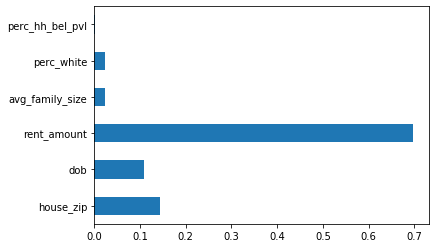

In [33]:
X2 = final_data_wdemo.drop(['count_arrear_mths_1yr','risk_rating'], axis=1)
Y1 = final_data_wdemo['risk_rating']
model = ExtraTreesClassifier()
model.fit(X2,Y1)
print(model.feature_importances_) 

#plot graph of feature importance
feat_importances = pd.Series(model.feature_importances_, index=X2.columns)
feat_importances.plot(kind='barh')
plt.show()

In the above figure, it can be seen that the demographic features added, have very little predictive power in comparison to the rent_amount, dob, or house_zip. This could be because of the large amount of missing data for those 3 features for 43 zipcodes(81-38). We had used imputed values for these missing NA values, which explains the poor predictive power of these features. 

As discussed earlier, 'perc_hh_bel_pvl' has almost negligible predictive power. This could be because, most of the values in this field were set as 0 (which might be wrong). Hence, the data from the source was already significantly incomplete. Hence, we should drop this variable from subsequent models altogether. 

The above independent variables are used in the case where we want to predict the risk rating of a newly added tenant who has no payment history. However, for existing tenants as in the given data set we would also include the 'count_arrear_mths_1yr' variable as discussed above. So now the realtive feature importances become.

[0.08969754 0.0479646  0.18334315 0.62326254 0.02627623 0.02740325
 0.00205269]


C:\Users\Fay_Asus\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


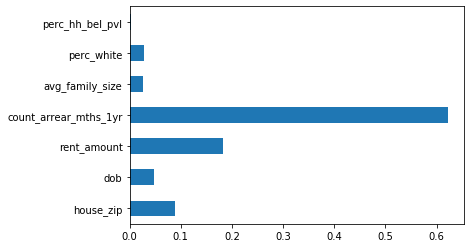

In [34]:
X3 = final_data_wdemo.drop(['risk_rating'], axis=1)
Y1 = final_data['risk_rating']

model = ExtraTreesClassifier()
model.fit(X3,Y1)
print(model.feature_importances_) 

#plot graph of feature importance
feat_importances = pd.Series(model.feature_importances_, index=X3.columns)
feat_importances.plot(kind='barh')
plt.show()

It can be seen that 'count_arrear_mths_1yr' is a strong feature in comparison to the rest of the features in predicting the risk rating of the tenants. This is because a risk of default strongly depends on how often a person makes a deficit (or 0) payment for his rent. Indeed this would cause him to roll his arrears and send him into a spiral of long term arrear. 

In [35]:
# dropping perc_hh_bel_pvl variable from the data set owing to its low predictive power. 
final_data_wdemo = final_data_wdemo.drop(['perc_hh_bel_pvl'], axis = 1)
final_data_wdemo.head(10)

,house_zip,dob,rent_amount,count_arrear_mths_1yr,risk_rating,avg_family_size,perc_white
0,92194,1975.0,1720.0,0.0,0,2.97,0.60
1,92198,1975.0,1619.0,0.0,0,2.97,0.60
2,92161,1975.0,1143.0,0.4,2,2.97,0.60
3,92107,1975.0,1802.0,0.0,0,2.69,0.92
4,92160,1975.0,1269.0,0.0,0,2.97,0.60
5,92169,1975.0,1650.0,0.4,0,2.97,0.60
6,92172,1975.0,948.0,0.0,0,2.97,0.60
7,92124,1975.0,1279.0,0.0,0,3.27,0.71
8,92127,1975.0,1446.0,2.0,0,3.35,0.52
9,92161,1975.0,1531.0,0.0,0,2.97,0.60


## Objective 3 & 4: Predictive model for each of the tenants distinguishing between short, medium and long term arrears (in terms of risk ratings)

In [36]:
# import machine learning librarires

from sklearn import metrics
from sklearn.utils import shuffle
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from sklearn.metrics import confusion_matrix
from IPython.display import Image  
import pydotplus


C:\Users\Fay_Asus\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


We'll be developing 2 models: 

(1) New_tenants: for newly added in tenants which would include the following variables:  
  
* house_zip
* dob
* rent_amount
* avg_family_size
* perc_white

These are variables that are readily available for any newly added in tenant. This model can be used for predicting if a newly added in tenant will have a risk of defaulting. 

(2) Exist_tenants: for existing tenants in the database with a payment history, which would include the following variables: 

* house_zip
* dob
* rent_amount
* avg_family_size
* perc_white
* count_arrear_mths_1yr

In [37]:
final_data1 = shuffle(final_data_wdemo, random_state = 2) #set fixed seed for shuffle to shuffle once only
trg_data = final_data1.iloc[:1200]
val_data = final_data1.iloc[1200:1800]
test_data = final_data1.iloc[1800:]

In [38]:
trg_data.head()

,house_zip,dob,rent_amount,count_arrear_mths_1yr,risk_rating,avg_family_size,perc_white
347,92153,1975.0,1237.0,0.8,0,2.97,0.60
1441,92179,1986.0,1399.0,0.4,0,2.97,0.60
2229,92129,1975.0,1700.0,3.4,1,3.30,0.48
1777,92113,1975.0,1822.0,0.0,0,4.28,0.63
140,92196,1975.0,1565.0,0.0,0,2.97,0.60


In [39]:
# for New_tenants model
X_trg_data1 = trg_data.drop(columns = ['count_arrear_mths_1yr', 'risk_rating'])
Y_trg_data1 = trg_data['risk_rating']


X_val_data1 = val_data.drop(columns = ['count_arrear_mths_1yr', 'risk_rating'])
Y_val_data1 = val_data['risk_rating']

X_test_data1 = test_data.drop(columns = ['count_arrear_mths_1yr', 'risk_rating'])
Y_test_data1 = test_data['risk_rating']

#train the model on training data
new_tenants = DecisionTreeClassifier()
new_tenants_tree = new_tenants.fit(X_trg_data1,Y_trg_data1)

# calculate the accuracy of this tree on validation set
y_pred_on_val = new_tenants_tree.predict(X_val_data1)
print("Accuracy on validation set using new_tenants model: ", round(metrics.accuracy_score(Y_val_data1,y_pred_on_val)*100,1),'%')

Accuracy on validation set using new_tenants model:  59.8 %


In [40]:
# for Exist_tenants model
X_trg_data2 = trg_data.drop(columns = ['risk_rating'])
Y_trg_data1 = trg_data['risk_rating']


X_val_data2 = val_data.drop(columns = ['risk_rating'])
Y_val_data1 = val_data['risk_rating']

X_test_data2 = test_data.drop(columns = ['risk_rating'])
Y_test_data1 = test_data['risk_rating']

#train the model on training data
exist_tenants = DecisionTreeClassifier()
exist_tenants_tree = exist_tenants.fit(X_trg_data2,Y_trg_data1)

# calculate the accuracy of this tree on validation set
y_pred_on_val = exist_tenants_tree.predict(X_val_data2)
print("Accuracy on validation set using exist_tenants model: ", round(metrics.accuracy_score(Y_val_data1,y_pred_on_val)*100,1),'%')

Accuracy on validation set using exist_tenants model:  82.0 %


It can be seen that the accuracy of the new_tenants model on the validation dataset (using decision tree classifier) is lower, under 60%. This is expected as only one of the indepedent features (rent_amount) is a reasonably strong predictor. The others are poor indicators: 
- dob, which had many datapoints that were missing due to erroneous data entry
- house_zip which is actually a variable with much more implicit information but owing to its numerical chanracteristic, it will be taken as a continuous numerical variable by the model. Hence, expected to have low accuracy.
- Other demographic variables which we already established as having poor predictive power. 

However, in the exist_tenants model, we have more information on the tenants based on their payment history which is very powerful in predicting the risk of default of an individual. Hence, this model has a very high accuracy on the validation dataset (using decision tree classifier) around 83%. 

#### We'll perform further analysis based on the exist_tenants model applying other machine learning approaches with this model to evaluate the accuracy. 

In [41]:
# check the current depth of exist_tenants_tree
print('Depth of tree: ', exist_tenants_tree.tree_.max_depth)

Depth of tree:  23


In [42]:
# post pruning of the tree

tree_0 = exist_tenants_tree
depth_list = []
trg_accuracy_list = []
val_accuracy_list = []
for i in range(1,tree_0.tree_.max_depth+1):
    clf = DecisionTreeClassifier(max_depth=i)
    clf = clf.fit(X_trg_data2,Y_trg_data1)
    y_pred_train = clf.predict(X_trg_data2)
    y_pred_val = clf.predict(X_val_data2)
    depth_list.append(i)
    trg_accuracy_list.append(metrics.accuracy_score(Y_trg_data1,y_pred_train))
    val_accuracy_list.append(metrics.accuracy_score(Y_val_data1,y_pred_val))
trg_accuracy_list = [round(i,3) for i in trg_accuracy_list]
val_accuracy_list = [round(i,3) for i in val_accuracy_list]
print(depth_list)
print(trg_accuracy_list)
print(val_accuracy_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
[0.901, 0.908, 0.908, 0.91, 0.912, 0.918, 0.923, 0.928, 0.938, 0.945, 0.948, 0.957, 0.963, 0.97, 0.975, 0.987, 0.991, 0.992, 0.995, 0.998, 0.998, 0.999, 1.0]
[0.88, 0.877, 0.877, 0.87, 0.87, 0.867, 0.868, 0.863, 0.863, 0.852, 0.85, 0.842, 0.843, 0.837, 0.842, 0.835, 0.82, 0.823, 0.827, 0.823, 0.822, 0.825, 0.828]


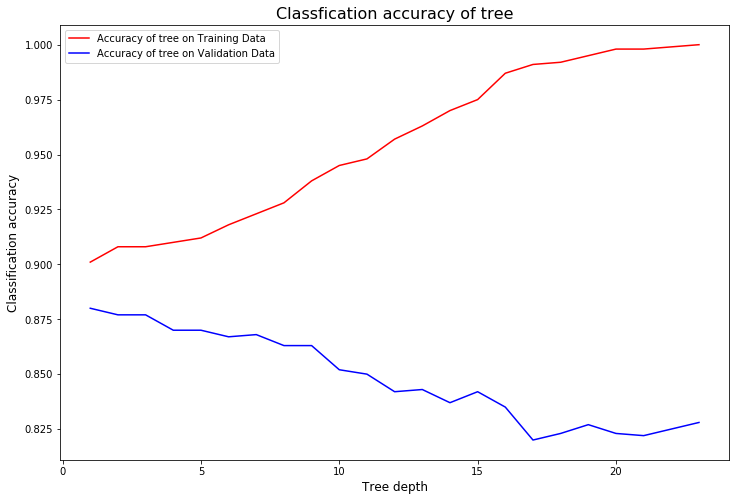

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))

plt.plot(depth_list, trg_accuracy_list,'red', label='Accuracy of tree on Training Data')
plt.plot(depth_list, val_accuracy_list, 'blue', label='Accuracy of tree on Validation Data')


plt.xlabel('Tree depth', fontsize = 12)
plt.ylabel('Classification accuracy',fontsize = 12)
plt.legend()
plt.title("Classfication accuracy of tree",fontsize = 16)
plt.show()

It can be seen that the classification accuracy of the model on the validation data set decreases significantly after a depth of 4, but remains at around 83% for subsequent levels of the tree. It can be assumed that after a depth of 4, further classification of the data in a decision tree does not bring about a signficant increase in the prediction accuracy on unseen data. This could be because there could be other factors that need to be considered before we can make a meaningful prediction on the behavior of the data. We could use this post-pruning approach to avoid overfitting of the training data by pruning the tree at a depth of 4 and an accuracy of around 87% on unseen data. 

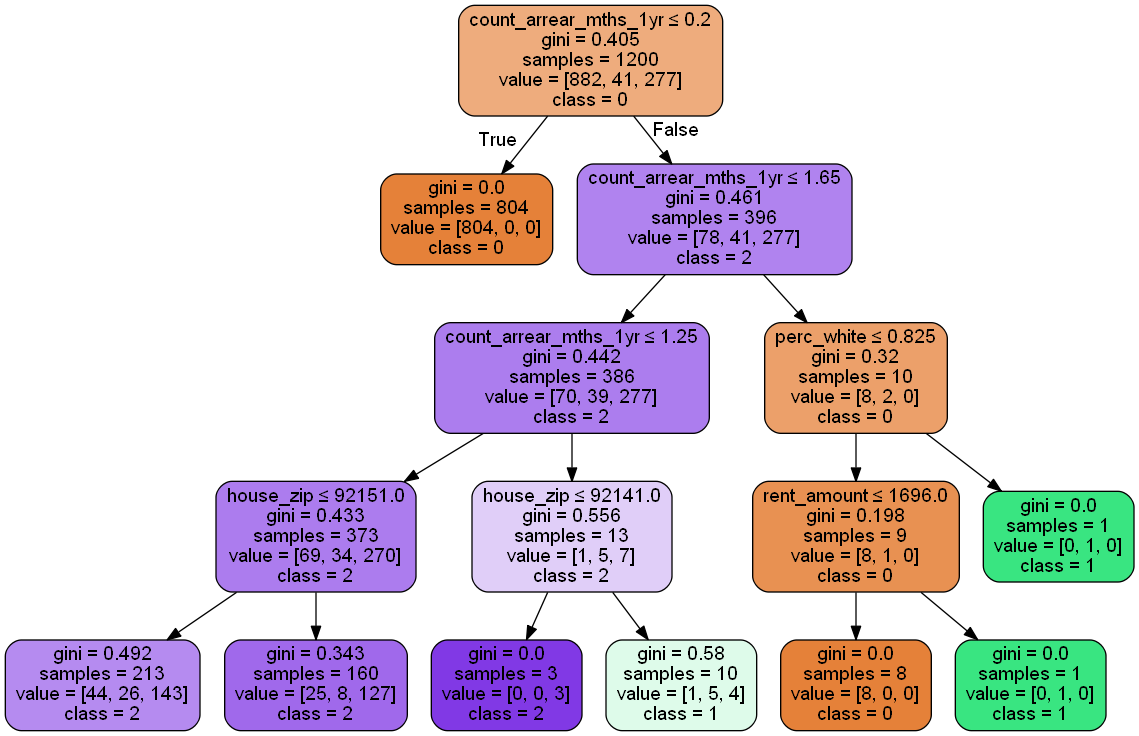

In [44]:
tree_4 = DecisionTreeClassifier(max_depth = 4)
tree_4 = tree_4.fit(X_trg_data2, Y_trg_data1)

# Plot the decision tree
import graphviz
feature_cols= list(X_trg_data2.columns.values)
dot_data = StringIO()
export_graphviz(tree_4, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1','2'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('tree_classifier.png')
Image(graph.create_png())

#### We can try establishing a new classifier using kNN approach

While decision trees are not affected by and do not require the data to be normalised, for kNN classification we need to scale the data using an appropriate normalisation approach. This is because kNN approach relies on the calculation of the Euclidean distance (or the 2-norm) to determine the nearest neighbours and if not normalised, the data could be skewed on one or many of the axes (independent variables) rendering our classification inaccurate.

In [46]:
# normalise x data using z-score normalisation
from sklearn.preprocessing import StandardScaler

scaled_xtrain = StandardScaler().fit(X_trg_data2).transform(X_trg_data2) # fit on training data and transform training data
scaled_xval = StandardScaler().fit(X_trg_data2).transform(X_val_data2)   # transform validation data
scaled_xtest = StandardScaler().fit(X_trg_data2).transform(X_test_data2) # transform test data
Y_trg_data1 = np.asarray(Y_trg_data1).ravel()
Y_val_data1 = np.asarray(Y_val_data1).ravel()
Y_test_data1 = np.asarray(Y_test_data1).ravel()


In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
accuracy_list = []
for i in range(1,101):
     knn = KNeighborsClassifier(n_neighbors=i)
     knn.fit(scaled_xtrain,Y_trg_data1)                       # fit on training data
     y_pred_on_val_knn = knn.predict(scaled_xval)            # predict on validation data
     accuracy = accuracy_score(Y_val_data1,y_pred_on_val_knn) # compare predicted and actual values
     accuracy_list.append(accuracy)

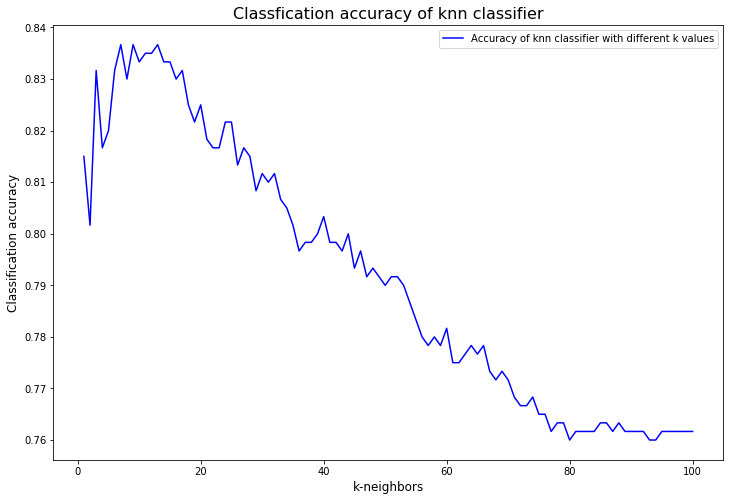

Classifier with k = 7  is the best classifier with accuracy is 83.7 %


In [48]:
plt.figure(figsize=(12,8))
k_list = list(range(1,101))
plt.plot(k_list, accuracy_list,'blue', label='Accuracy of knn classifier with different k values')


plt.xlabel('k-neighbors', fontsize = 12)
plt.ylabel('Classification accuracy',fontsize = 12)
plt.legend()
plt.title("Classfication accuracy of knn classifier",fontsize = 16)
plt.show()
print("Classifier with k =",accuracy_list.index(max(accuracy_list))+1," is the best classifier with accuracy is",round(max(accuracy_list)*100,1),"%",sep=" ")  

It can be seen that the accuracy of the classifiers starts decreasing drastically after k-value of around 11. The model suffers from overfitting of the training data at a high k-value. kNN classification yields lower degree of accuracy at low k-values but reaches an optimum once the model is sufficiently trained. In this case it appears to be around k=11.

#### Compare performance of both the chosen classifiers on the test data

In [49]:
# for tree with a depth of 4
y_pred_test_tree_4 = tree_4.predict(X_test_data2)
print('The accuracy of the decision tree classifer with a depth of 4 has', \
      round(metrics.accuracy_score(Y_test_data1,y_pred_test_tree_4),3)*100,'% accuracy')

# for knn with k = 11
knn_11 = KNeighborsClassifier(n_neighbors=11)
knn_11.fit(scaled_xtrain,Y_trg_data1)                       
y_pred_test_knn11 = knn_11.predict(scaled_xtest)            
print('The accuracy of the kNN classifier with 11 neighbours has', \
      round(metrics.accuracy_score(Y_test_data1,y_pred_test_knn11),3)*100,'% accuracy')


The accuracy of the decision tree classifer with a depth of 4 has 87.2 % accuracy
The accuracy of the kNN classifier with 11 neighbours has 81.2 % accuracy


We can identify that based on the current data set, for the exist_tenants model (i.e. with the independent features - 'house_zip', 'dob', 'rent_amount', 'avg_family_size', 'perc_white' and 'count_arrear_mths_1yr') the decision tree classifier with a depth of 4 is a sufficiently accurate classifier in comparison to a knn classifier with k = 11 (which is the best k value in terms of accuracy) based on its performance on both the validation and test data set. However, it is important for us to consider other factors that affect the accuracy too.

In [52]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test_data1,y_pred_test_tree_4, labels=[0, 1, 2])
cm

array([[422,   3,  47],
       [  4,   0,  28],
       [  1,   3, 162]], dtype=int64)

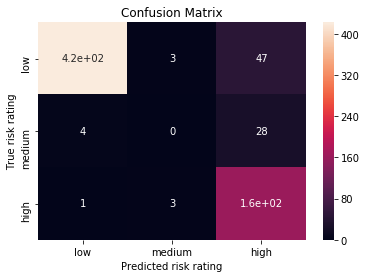

In [54]:
import seaborn as sns

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); 

# labels, title and ticks
ax.set_xlabel('Predicted risk rating');ax.set_ylabel('True risk rating'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['low', 'medium', 'high']); ax.yaxis.set_ticklabels(['low', 'medium', 'high']);

## Summary of Findings  

From the decision tree depicted earlier, as expected, if the count of arrears is less than or equal to 0.2 the risk of arrear debt is low (=0) with zero error (Gini index = 0).  

Otherwise, at the next level of the at decision tree, if the count of arrears is less than or equal to 1.65 the risk of arrear debt is classified either as medium or high. Alternatively, the risk of arrear debt is classified as low or medium. In the training data the majority of the cases where count_arrear_mths_1yr is greater than 0.2 (277 of 396 samples) will be high risk.  
  
In the latter case, we can see that the model does a good job in classifying risk on the training data, and will classify as low risk cases where the rent amount is less than 1696 and the % of White peole is less than or equal to 82.5%. The remaining cases are classified as medium risk.  
  
In the case where the count of arrears is less than or equal to 1.65, five out of the six terminal nodes are the high risk class and one node is medium. However, we can see from the Gini index that impurity is relatively large in this class.  
  
Moreover, form the confusion matrix, we understand that our model does a good job in predicting correctly the low risk tenats in the test data (422 of 472), and a very good job in classifying high risk correctly (162 of 166). However, what is concerning is the large amount of false positives (high risk). More than 10% of low risk tenants and almost all of the medium risk tenants in the test set are classified as high risk.  

## Recommendations  

Based on the above analysis we can conclude that there is no strong predictor, in saying whether the tenant is going to fall into arrears debt. We need to be conscious of the damage eviction may cause to tenants with low risk both personally and in the housing association's reputation, while at the same time we should be cautious of losses from long-term unpaid rent.  
  
Due to the sensitive nature of the matter we recommend that the housing association uses a tree of depth 2 in the decsion making.  
  
As long a tenant does not have count_arrear_mths_1yr greater than 0.2 they are considered to be low risk and the housing association should not spend resources on these risk grade tenants.  
  
We recommend that tenants who have count_arrear_mths_1yr between 0.2 and 1.65 are given a warning of eviction as in the majority of cases these will be high risk tenants. If the behaviour persists it is in the landlord legal right to start court proceedings to evict the tenant with arrear debt.  
  
In the case where count_arrear_mths_1yr is over 1.65, we recommend that the housing association does not take immediate action but monitors the payment behaviour of tenants to ensure they continue to remain in low - medium risk grade. 


## Considerations / Limitations  

* A fairly large amount of assumptions have been made in the cleaning of an incomplete and inconsistent dataset to ensure good quality data to base our decision on. In the case where incorrect assumptions and/or interpretations are made, the conclusion will be wrong. In a real-world project we would consult with stakeholders on the business rules on data entry and collection  
<br>  
* Since a large amount of dob has been imputed using the mean, dob cannot be a strong predictor in our model as can be seen from the decision tree above. There is not a sufficiently large information gain from age of tenant what could usually be considered an intuitively good indicator.   
<br>  
* We have assumed that rent_amount is the same per tenant per house in our analysis. In reality a rent increase is possible due to inflation and other factos  
<br>  
* To understand the risk of arrear debt we have looked at the duration of owed rent. If a tenant misses 3 payments and then moves out of the property he will appear as mid risk although in reality he may not repay the debt  
<br>  
* We have assumed that when no rent payment was made this has been recorded as blank which we subsequently replaced with 0. If there is inconsistency in the way 'no payment' was recorded, i.e. if missing month means no payment, this will not be identified and accumulated arrears, count of arrears and duration of arrears will be underestimated. 

## References

1) Table 1 — Total population, median age, sex, age, household and family size, 2010, State of California, Department of Finance, viewed 11 July <http://www.dof.ca.gov/Reports/Demographic_Reports/Census_2010/>


2) Table 3c — Population by Race (Hispanic Origin exclusive) and Hispanic Origin, 2010, State of California, Department of Finance, viewed 11 July <http://www.dof.ca.gov/Reports/Demographic_Reports/Census_2010/>


3) 2016 San Diego County Demographics - Families in Poverty, 2016, San Diego County, viewed 11 July 
<https://data.sandiegocounty.gov/Demographics/2016-San-Diego-County-Demographics-Families-in-Pov/ayc4-bmye>